In [2]:
import itertools
import math
import os

import gsd.hoomd
import hoomd
import matplotlib
import matplotlib_inline
import numpy

%matplotlib inline
matplotlib.style.use("ggplot")
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [3]:
m = 4
N_particles = 2 * m**3
spacing = 1.2
K = math.ceil(N_particles ** (1 / 3))
L = K * spacing
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)
position = list(itertools.product(x, repeat=3))
position = position[0:N_particles]
orientation = [(1, 0, 0, 0)] * N_particles

# gsd snapshot
snapshot = gsd.hoomd.Frame()
snapshot.particles.N = N_particles
snapshot.particles.position = position
snapshot.particles.orientation = orientation
snapshot.particles.typeid = [0] * N_particles
snapshot.particles.types = ["A"]
snapshot.configuration.box = [L, L, L, 0, 0, 0]
# Some file checking, if the file exists, remove it
if(os.path.exists("/home/user/sticky_particles/snapshots/initial.gsd")):
    os.remove("/home/user/sticky_particles/snapshots/initial.gsd")

with gsd.hoomd.open(name="/home/user/sticky_particles/snapshots/initial.gsd", mode="x") as f:
    f.append(snapshot)

# build simulation
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=0)
simulation.create_state_from_gsd(filename="/home/user/sticky_particles/snapshots/initial.gsd")

Define the parameters delta, epsilon, lambda, and sigma of the Kern–Frenkel model. Start the simulation at a high temperature kT = 3.0

In [4]:
delta = math.pi / 4
epsilon = 1.0
lambda_ = 1.2
sigma = 1.0
kT = 3.0

Use the Sphere HPMC integrator to implement the hard core portion of the Kern-Frenkel interaction potential. Also pass the temperature kT to the integrator. HPMC does not apply rotation moves to spheres by default. Set the orientable key to True so that HPMC will rotate the particles.

In [5]:
mc = hoomd.hpmc.integrate.Sphere(kT=kT)
mc.shape["A"] = dict(diameter=sigma, orientable=True)
simulation.operations.integrator = mc

HOOMD-blue represents the Kern-Frenkel potential as a product of an isotropic potential and an orientation dependent mask. The isotropic potential depends only on distance and the orientation dependent mask depends only on the relative position and orientation.

Represent the isotropic part of the Kern-Frenkel potential with a Step potential:

In [6]:
step = hoomd.hpmc.pair.Step()
step.params[("A", "A")] = dict(epsilon=[-epsilon], r=[lambda_ * sigma])

Mask the isotropic step potential with an angular dependent factor computed by AngularStep:

In [7]:
angular_step = hoomd.hpmc.pair.AngularStep(isotropic_potential=step)
angular_step.mask["A"] = dict(directors=[(1.0, 0, 0)], deltas=[delta])

The HPMC integrator will evaluate all pair potentials in its pair_potentials attribute when making trial moves. Add angular_step to this list:

In [8]:
mc.pair_potentials = [angular_step]

You can query the energy associated with the patch potential via the energy property of the angular step object (after running for 0 or more steps). The particles are not interacting in the initial configuration, so the initial value of the energy is zero.

In [9]:
simulation.run(0)
angular_step.energy

0.0

In [10]:
# Assume you have a simulation object already set up:
snap = simulation.state.get_snapshot()

# Positions are a numpy array of shape (N_particles, 3)
positions = snap.particles.position

Log the Patch Energy
Use a Logger to write the total system potential energy to a GSD file.

In [11]:
# Some file checking, if the file exists, remove it
if(os.path.exists("/home/user/sticky_particles/log/patchy_log.gsd")):
    os.remove("/home/user/sticky_particles/log/patchy_log.gsd")

logger = hoomd.logging.Logger()
logger.add(
    mc,
    quantities=["pair_energy"],
)
gsd_writer = hoomd.write.GSD(
    filename="/home/user/sticky_particles/log/patchy_log.gsd",
    trigger=hoomd.trigger.Periodic(10),
    mode="xb",
    filter=hoomd.filter.Null(),
    logger=logger,
)
simulation.operations.writers.append(gsd_writer)

The initial temperature kT is large enough that bonds between particles are likely to break. Run the simulation to randomize the particle degrees of freedom:

In [12]:
simulation.run(500)

Decrease the temperature and run the simulation longer. The particles will form clusters

In [13]:
mc.kT = 0.1
simulation.run(2000)

Increase the temperature and the clusters will break apart.

In [14]:
mc.kT = 3.0
simulation.run(2000)

In [15]:
simulation.operations.writers.remove(gsd_writer)
del gsd_writer

Read the logged values

In [16]:
data = gsd.hoomd.read_log("/home/user/sticky_particles/log/patchy_log.gsd")
step = data["configuration/step"]
potential_energy = data["log/hpmc/integrate/Sphere/pair_energy"]

Plot the energy as a function of timestep:

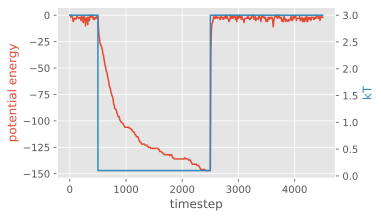

In [17]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
ax.plot(step, potential_energy, c="C0")
ax.set_xlabel("timestep")
ax.set_ylabel("potential energy", c="C0")

ax2 = ax.twinx()
ax2.grid(False)
ax2.plot([0, 500, 501, 2500, 2501, 4500], [3.0, 3.0, 0.1, 0.1, 3.0, 3.0], c="C1")
ylabel = ax2.set_ylabel("kT", c="C1")

fig